In [ ]:
!pip install gymnasium gymnasium[box2d]

In [52]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import gymnasium as gym
from google.colab import widgets
from gym import spaces
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import pandas as pd

In [53]:
def weather_flight_data():
    dataset = pd.read_csv("training/test_data.csv")
    weather_features = [
        "PRCP",
        "SNOW",
        "SNWD",
        "TMAX",
        "AWND",
        "LATITUDE",
        "LONGITUDE",
        "DEP_AIRPORT_HIST",
        "DAY_HISTORICAL",
        "DEP_DEL15",
    ]
    dataset = dataset[weather_features]
    dataset.dropna(inplace=True)

    return dataset


def get_weather_flight(flight_index, test_data):
    return test_data.iloc[flight_index][:-1].to_numpy()

In [54]:
dataset = weather_flight_data().head()
dataset

,PRCP,SNOW,SNWD,TMAX,AWND,LATITUDE,LONGITUDE,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_DEL15
0,0.03,0.0,0.0,39.0,4.25,39.048,-84.669,0.148545,0.201711,0
1,0.00,0.0,0.0,51.0,5.37,40.784,-111.967,0.173816,0.135706,0
2,0.00,0.0,0.0,83.0,3.13,43.142,-89.337,0.138516,0.165247,0
3,0.00,0.0,0.0,87.0,7.16,33.641,-84.427,0.248677,0.211041,0
4,0.02,0.0,0.0,88.0,6.04,40.784,-111.967,0.187867,0.203313,0


In [55]:
class AirportEnv(gym.Env):
    def __init__(self, weather_api, max_flights=10):
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(9,)) 
        self.action_space = gym.spaces.Discrete(2)

        # Train the model that Joel Solomone and Miheer Made. (Random Forest).
        self.model = pickle.load(open("training/gboostClassifier.dat", "rb"))
        # Test Data - 600 flights (rows)
        self.test_data = weather_flight_data()

        # it is like data to consider in stock market environment. Flight to consider.
        self.max_flights = min(max_flights, len(self.test_data))
        self.current_flight = 0
        self.current_weather = get_weather_flight(self.current_flight, self.test_data)
        self.n_flight = 0
        self.timestep = 0
        self.reset()

    def reset(self):
        self.total_rewards = 0
        self.done = False
        self.current_flight = 0
        self.n_flight = 0
        self.current_weather = get_weather_flight(self.current_flight, self.test_data)
        # Return the current state of the weather..
        return np.reshape(self.current_weather, (1, 9)), {"total_rewards":self.total_rewards}

        return np.reshape(self.current_weather, (1, 9)), {}

    def step(self, action):
        # Timestep can be configured to reflect how many flights are about to take off.
        # Take an action.
        # self.action(act=action)
        # This is for computing the rewards based on action.
        reward = self.computeRewards(action=action)
        self.total_rewards += reward

        self.n_flight += 1
        if self.n_flight >= self.max_flights - 1:
            self.done = True

        info = {"Flight": self.n_flight, "total_rewards":self.total_rewards}
        self.current_flight += 1

        self.current_weather = get_weather_flight(self.current_flight, self.test_data)

        return np.reshape(self.current_weather, (1, 9)), reward, self.done, info


    def computeRewards(self, action):
        reward = 0
        weather_features = self.current_weather
        prediction = self.model.predict(weather_features.reshape(1, -1))[0]

        if action == prediction:
            reward += 10
        else:
            reward -= 10

        # Additional factors based on the weather conditions
        WIND_SPEED_FACTOR = 0.1
        TEMPERATURE_FACTOR = 0.05
        PERCIPITATION_FACTOR = 0.2
        OVERALL_WEATHER_CONDITION_FACTOR = 0.5

        wind_speed = weather_features[4]
        temperature = weather_features[3]
        percipitation = weather_features[0]
        overall_weather_condition = weather_features[2]

        reward -= wind_speed * WIND_SPEED_FACTOR
        reward -= temperature * TEMPERATURE_FACTOR
        reward -= percipitation * PERCIPITATION_FACTOR
        reward -= overall_weather_condition * OVERALL_WEATHER_CONDITION_FACTOR

        # Penalize if the flight is not delayed, but there is a safety issue
        HAZARDOUS_WEATHER_THRESHOLD = 3
        if overall_weather_condition >= HAZARDOUS_WEATHER_THRESHOLD and action == 2:
            SAFETY_PENALTY = -5
            reward += SAFETY_PENALTY

        return reward

    def render(self, mode='human'):
        weather_features = [
            "PRCP",
            "SNOW",
            "SNWD",
            "TMAX",
            "AWND",
            "LATITUDE",
            "LONGITUDE",
            "DEP_AIRPORT_HIST",
            "DAY_HISTORICAL"
        ]
        
        if mode == 'human':
            print("Flight number:", self.n_flight)
            print("Weather data:")
            for i, feature in enumerate(weather_features[:-1]):  # Exclude the target (DEP_DEL15)
                print(f"  {feature}: {self.current_weather[i]}")
        elif mode == 'graph':
            weather_data = self.current_weather[:-1]  # Exclude the target (DEP_DEL15)
            plt.bar(weather_features[:-1], weather_data)
            plt.xlabel('Weather Features')
            plt.ylabel('Values')
            plt.title('Weather Data for Flight {}'.format(self.n_flight))
            plt.xticks(rotation='vertical')  # Make x-axis labels vertical
            plt.show()
        else:
            raise NotImplementedError("Render mode '{}' is not supported.".format(mode))




In [56]:
env = AirportEnv(None, max_flights=10)

In [57]:
obs = env.reset()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
obs[0].shape

(1, 9)

In [59]:
env.step(1)

(array([[   0.        ,    0.        ,    0.        ,   51.        ,
            5.37      ,   40.784     , -111.967     ,    0.17381562,
            0.13570632]]),
 -12.381,
 False,
 {'Flight': 1, 'total_rewards': -12.381})

### **Run Random Agent**

In [60]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def step(self, obs):
    return np.random.choice(self.action_space.n)

In [61]:
agent = RandomAgent(env)
obs, info = env.reset()
terminated = False
while not terminated:
  action = agent.step(obs)
  #self.current_weather, self.reward, self.done, info
  obs, reward, terminated, info = env.step(action)
  print("Action: ", action)
  print("Reward: ", reward)
  print("TerminateD: ", terminated)
  print("Total_rewards: ", info["total_rewards"])
  

Action:  0
Reward:  7.618999999999999
TerminateD:  False
Total_rewards:  7.618999999999999
Action:  0
Reward:  6.9129999999999985
TerminateD:  False
Total_rewards:  14.531999999999996
Action:  0
Reward:  5.536999999999999
TerminateD:  False
Total_rewards:  20.068999999999996
Action:  1
Reward:  -15.065999999999999
TerminateD:  False
Total_rewards:  5.002999999999997
Action:  0
Reward:  4.992000000000001
TerminateD:  False
Total_rewards:  9.994999999999997
Action:  1
Reward:  -13.401
TerminateD:  False
Total_rewards:  -3.4060000000000024
Action:  1
Reward:  -14.061
TerminateD:  False
Total_rewards:  -17.467000000000002
Action:  1
Reward:  -14.721
TerminateD:  False
Total_rewards:  -32.188
Action:  1
Reward:  -15.813
TerminateD:  True
Total_rewards:  -48.001000000000005


In [62]:
env.render()

Flight number: 9
Weather data:
  PRCP: 0.0
  SNOW: 0.0
  SNWD: 0.0
  TMAX: 90.0
  AWND: 8.5
  LATITUDE: 33.641
  LONGITUDE: -84.427
  DEP_AIRPORT_HIST: 0.18786731291566


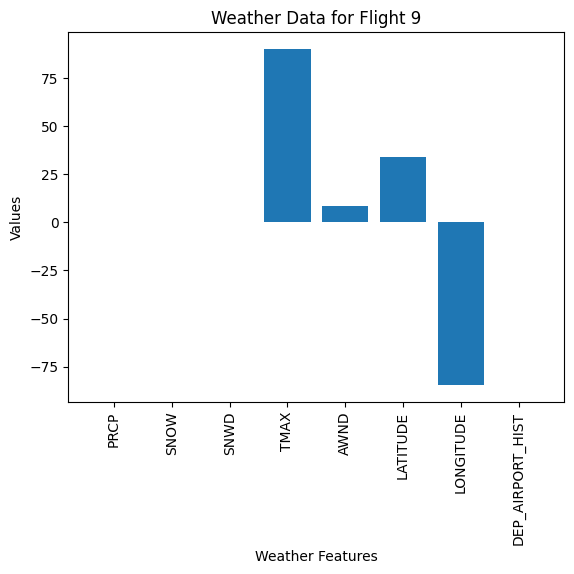

In [63]:
env.render('graph')

### Solving the Environment: Deep QNetwork

*Defining* *Model*

In [64]:
class Model:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()

    def build_model(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(24, activation='relu')(inputs)
        x = tf.keras.layers.Dense(24, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001))
        return model

    def predict(self, state):
        return self.model.predict(state)

    def fit(self, state, target, **kwargs):
        return self.model.fit(state, target, **kwargs)


In [65]:
class DQN_F:
    def __init__(self, batch_size, learning_rate, gamma, epsilon, epsilon_decay, memory_size, env, model, state_size, action_size):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)
        self.env = env
        self.model = model
        self.state_size = state_size
        self.action_size = action_size

        self.all_rewards = []
        self.al_epsilon_decay = []

        # Get average of weather features, 
        self.episode_predicted_values = []
        self.episode_weather_features = []


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1))
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, (1, self.state_size))
            next_state = np.reshape(next_state, (1, self.state_size))
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, num_episodes):
        for e in range(num_episodes):
            state, info = self.env.reset()
            state = np.reshape(state, (1, self.state_size))
            episode_predicted_values = []
            episode_weather_features = []

            for time in range(500):
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)
                next_state = np.reshape(next_state, (1, self.state_size))
                self.remember(state, action, reward, next_state, done)
                episode_predicted_values.append(action)
                episode_weather_features.append(state.reshape(-1))
                state = next_state
                if done:
                    print(f"episode: {e}/{num_episodes}, score: {time}, e: {self.epsilon:.2f}")
                    print("reward: {}".format(reward))
                    print("Total_rewards: ", info["total_rewards"])
                    break
            if len(self.memory) > self.batch_size:
                self.replay(self.batch_size)

            self.all_rewards.append(info["total_rewards"])
            self.al_epsilon_decay.append(self.epsilon)
            self.episode_predicted_values.append(episode_predicted_values)
            self.episode_weather_features.append(episode_weather_features)
            self.epsilon *= self.gamma
    def plotting_dqn_performance(self):
      episode_predicted_values = np.array(self.episode_predicted_values)
      episode_weather_features = np.array(self.episode_weather_features)   
      feature_x = 4 # AWND
      feature_y = 3 # TMAX
      plt.scatter(episode_weather_features[:, feature_x], episode_weather_features[:, feature_y], c=self.all_rewards, cmap='viridis')
      plt.xlabel("AWND")
      plt.ylabel("TMAX")
      plt.colorbar(label = "Total Rewards")
      plt.title("DQN Agent Performance Based on Weather Features")
      plt.show()


In [66]:
# Create an instance of the AirportEnv environment
weather_api = None  # Replace this with a valid weather API if required
max_flights = 10
env = AirportEnv(weather_api, max_flights)

# Create an instance of the Model class
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = Model(state_size, action_size)

# Create an instance of the DQN_F class
batch_size = 32
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
memory_size = 10000
num_episodes = 350

dqn = DQN_F(batch_size, learning_rate, gamma, epsilon, epsilon_decay, memory_size, env, model, state_size, action_size)

# Train the DQN agent
dqn.train(num_episodes)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
episode: 281/350, score: 8, e: 0.01
reward: -15.813
Total_rewards:  11.998999999999997
1/1 [==============================] - 0s 17ms/step
episode: 282/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.998999999999995
1/1 [==============================] - 0s 21ms/step
episode: 283/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.998999999999995
1/1 [==============================] - 0s 17ms/step
episode: 284/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.998999999999995
1/1 [==============================] - 0s 16ms/step
episode: 285/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.998999999999995
1/1 [==============================] - 0s 18ms/step
episode: 286/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.998999999999995
1/1 [==============================] - 0s 23ms/step
episode: 287/350, score: 8, e: 0.01
reward: 4.187
Total_rewards:  51.9989

*Start* *Training*

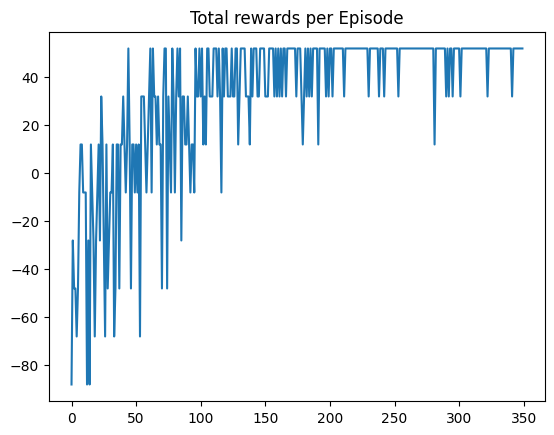

In [93]:
plt.title("Total rewards per Episode")
plt.plot(dqn.all_rewards)

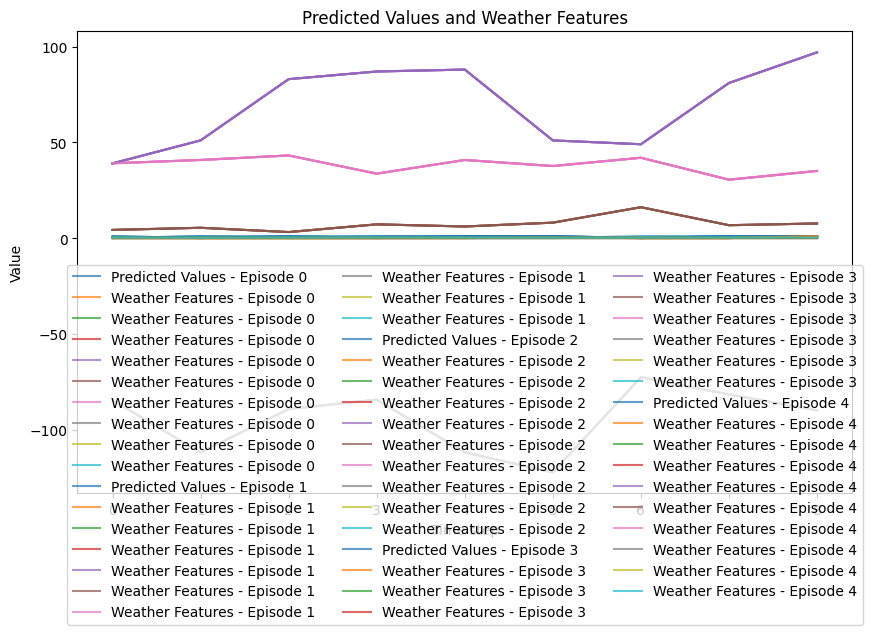

In [94]:
# Set the maximum number of episodes to plot
max_episodes_to_plot = 5

# Set the figure size
plt.figure(figsize=(10, 6))

for i, (predicted_values, weather_features) in enumerate(zip(dqn.episode_predicted_values, dqn.episode_weather_features)):
    if i >= max_episodes_to_plot:
        break
    plt.plot(predicted_values, label=f'Predicted Values - Episode {i}', alpha=0.7)
    plt.plot(weather_features, label=f'Weather Features - Episode {i}', alpha=0.7)

plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Predicted Values and Weather Features')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.show()


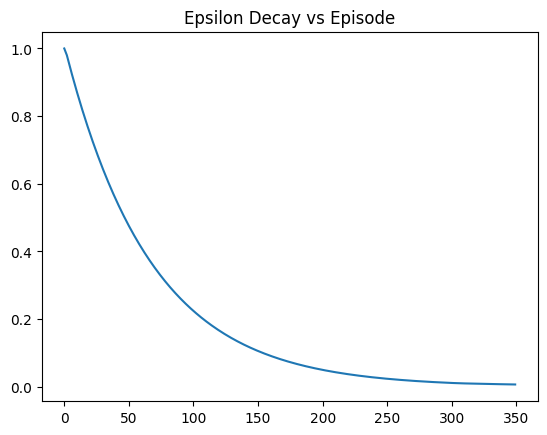

In [95]:
# Plot Epsilon Decay
plt.title("Epsilon Decay vs Episode")
plt.plot(dqn.al_epsilon_decay)

### **Actor Critic Model**

In [82]:
from tensorflow.keras import layers, Model
class Actor(Model):
  def __init(self, input_shape, output_shape):
    super(Actor, self).__init__()
    self.dense1 = layers.Dense(128, activation='relu', input_shape=(input_shape, ))
    self.dense2 = layers.Dense(256, activation='relu')
    self.dense3 = layers.Dense(output_shape)
  
  def forward(self, state):
    x = self.dense1(state)
    x = self.dense2(x)
    x = self.dense3(x)
    return tf.nn.softmax(x, axis=1)

class Critic(Model):
  class Critic(Model):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu', input_shape=(input_shape,))
        self.dense2 = layers.Dense(256, activation='relu')
        self.dense3 = layers.Dense(1)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.dense3(x)


Agent

In [89]:
from tensorflow.keras.optimizers import Adam

class Agent:
    def __init__(self, input_shape, output_shape, env, gamma=0.98, learning_rate=0.001):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.actor = Actor(input_shape, output_shape)
        self.critic = Critic(input_shape)
        self.optimizercritic = Adam(learning_rate=self.learning_rate)
        self.optimizeractor = Adam(learning_rate=self.learning_rate)
        self.output_shape = output_shape
        self.env = env

    def action(self, state):
        state = tf.reshape(state, (1, -1))
        probs = self.actor(state)
        action = np.random.choice(self.env.action_space.n, p=probs.numpy()[0])
        return action

    def update(self, transitions):
        state, action, rewards, next_state, dones = transitions
        states = tf.convert_to_tensor([state], dtype=tf.float32)
        next_states = tf.convert_to_tensor([next_state], dtype=tf.float32)
        rewards = tf.convert_to_tensor([rewards], dtype=tf.float32)
        action = tf.convert_to_tensor([action], dtype=tf.int64)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            actor_val = self.actor(states)
            critic_val = self.critic(states)

            next_q_val = self.critic(next_states)
            td_error = rewards + self.gamma * next_q_val - critic_val

            critic_loss = tf.math.square(td_error)
            action_prob = -tf.math.log(actor_val)
            actor_loss = action_prob * tf.stop_gradient(td_error)

        critic_grads = tape1.gradient(critic_loss, self.critic.trainable_variables)
        self.optimizercritic.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        actor_grads = tape2.gradient(actor_loss, self.actor.trainable_variables)
        self.optimizeractor.apply_gradients(zip(actor_grads, self.actor.trainable_variables))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
def train_actor_critic(env, agent, num_episodes=1000):
    all_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            action = agent.action(state)
            next_state, reward, done, info = env.step(action)

            transitions = (state, action, reward, next_state, done)
            agent.update(transitions)

            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode: {episode + 1}/{num_episodes}, Reward: {total_reward}")
        all_rewards.append(total_reward)

    return all_rewards


In [91]:
envE = AirportEnv(None, max_flights = 10)
input_shape = envE.observation_space.shape[0]
output_shape = envE.action_space.n

agent = Agent(input_shape, output_shape, envE)

all_rewards = train_actor_critic(envE, agent, num_episodes=1000)

ValueError: ignored